# 07 - Region Stratified Regressions

**Objectives**
* perform regressions per level1 region on ROIx1 plaque proximity index
* train GBM / other regressors per strata: `CX+KI->pp`, `BS+KI->pp`, etc..

In [1001]:
import pandas as pd
import numpy as np
import os
import pickle
import itertools

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from boruta import BorutaPy

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, ShuffleSplit
from sklearn.metrics import confusion_matrix

import lime 
from lime.lime_tabular import LimeTabularExplainer

import sklearn.datasets
from lime.lime_tabular import LimeTabularExplainer

sns.set(style="whitegrid")

---

## Load the data

In [2]:
wd = '/media/tmo/data/work/datasets/02_ST'

logcpm_path = wd + '/ashley_21.03.2018/logcpm_merge_20180212.pickle'
meta_path = wd + '/meta/meta.parquet'

In [3]:
%%time
meta_df = pd.read_parquet(meta_path)

CPU times: user 102 ms, sys: 290 ms, total: 392 ms
Wall time: 196 ms


In [4]:
%%time
logcpm_df = pickle.load(open(logcpm_path, "rb"))

logcpm_df.index.name = 'spot_UID'
logcpm_df.reset_index(inplace=True)
logcpm_df.rename(columns={'sampleID': 'slide_ID'}, inplace=True)

CPU times: user 16 s, sys: 6.78 s, total: 22.8 s
Wall time: 22.7 s


In [5]:
st_df = logcpm_df.merge(meta_df, how='inner', on=['spot_UID', 'slide_ID'])

In [6]:
st_df['slide_ID'] = st_df['slide_ID'].astype('category', copy=False)
st_df['GT'] = st_df['GT'].astype('category', copy=False)
st_df['age'] = st_df['age'].astype('category', copy=False)
st_df['age_GT'] = st_df['age_GT'].astype('category', copy=False)

In [7]:
n_genes = 46454
gene_columns = st_df.columns[1:n_genes+1]

* merge with satellite tables

In [10]:
region_levels_df = pd.read_csv('region_levels.csv', sep=',', keep_default_na=False)

In [378]:
final_meta_df = pd.read_csv('final_metadata_scores.tsv', sep='\t', index_col=0)
final_meta_df.index.name = 'spot_UID'
final_meta_df.reset_index(inplace=True)
final_meta_df = final_meta_df[final_meta_df['AB'].notna()][['spot_UID', 'AB']]

In [381]:
full_df = st_df \
    .merge(region_levels_df, on='Region_predict') \
    .merge(final_meta_df, on='spot_UID')

In [382]:
expression_df.head()

,-343C11.2,00R_AC107638.2,0610005C13Rik,0610006L08Rik,0610007P14Rik,0610009B22Rik,0610009E02Rik,0610009L18Rik,0610009O20Rik,0610010F05Rik,...,n-R5s90,n-R5s92,n-R5s93,n-R5s94,n-R5s95,n-R5s96,n-R5s97,n-R5s98,n-TSaga9,n-TStga1
0,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,4.984943,2.982974,2.982974,2.982974,...,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974
1,2.982974,2.982974,2.982974,2.982974,6.827059,5.924174,2.982974,2.982974,2.982974,2.982974,...,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974
2,2.982974,2.982974,2.982974,2.982974,2.982974,5.609164,2.982974,2.982974,5.609164,2.982974,...,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974
3,2.982974,2.982974,2.982974,2.982974,7.661385,2.982974,2.982974,2.982974,5.157746,5.157746,...,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974
4,2.982974,2.982974,2.982974,2.982974,6.738947,6.738947,2.982974,2.982974,2.982974,7.432553,...,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974,2.982974


In [383]:
expression_df = full_df[gene_columns]

In [388]:
AB_df = full_df[['AB']]

In [389]:
# assert expression_df.shape == (10327, 46454) 
assert expression_df.shape == (10324, 46454)  # 3 less = damaged spots

---

## Boruta feature selection
* perform Boruta feature selection using a RF regressor
* also check out [RFE](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html)

In [1019]:
boruta_genes_path = '07_results/boruta_genes.tsv'

* compute 

In [ ]:
# def do_boruta(estimator=RandomForestRegressor(n_jobs=-1, n_estimators=1000, max_features=0.005, max_depth=5),
#               X=expression_df,
#               y=AB_df,
#               verbose=0, 
#               seed=42):
    
#     feat_selector = BorutaPy(estimator=estimator, verbose=verbose, random_state=seed)
    
#     X = X.as_matrix()
#     y = y.values.ravel()
    
#     feat_selector.fit(X, y)
    
#     return feat_selector

In [ ]:
# %%time
# boruta_selector = do_boruta()

In [ ]:
# boruta_genes = gene_columns[boruta_selector.support_]

In [1020]:
# pd.DataFrame(boruta_genes).to_csv(boruta_genes_path, sep='\t', header=None, index=None)

* read from file

In [1025]:
boruta_genes = list(pd.read_csv(boruta_genes_path, sep='\t', header=None)[0])

In [1028]:
len(boruta_genes)

155

---

## Feature visualizations
* https://github.com/DistrictDataLabs/yellowbrick
* Docs: http://www.scikit-yb.org/en/latest/

### **Correlation**

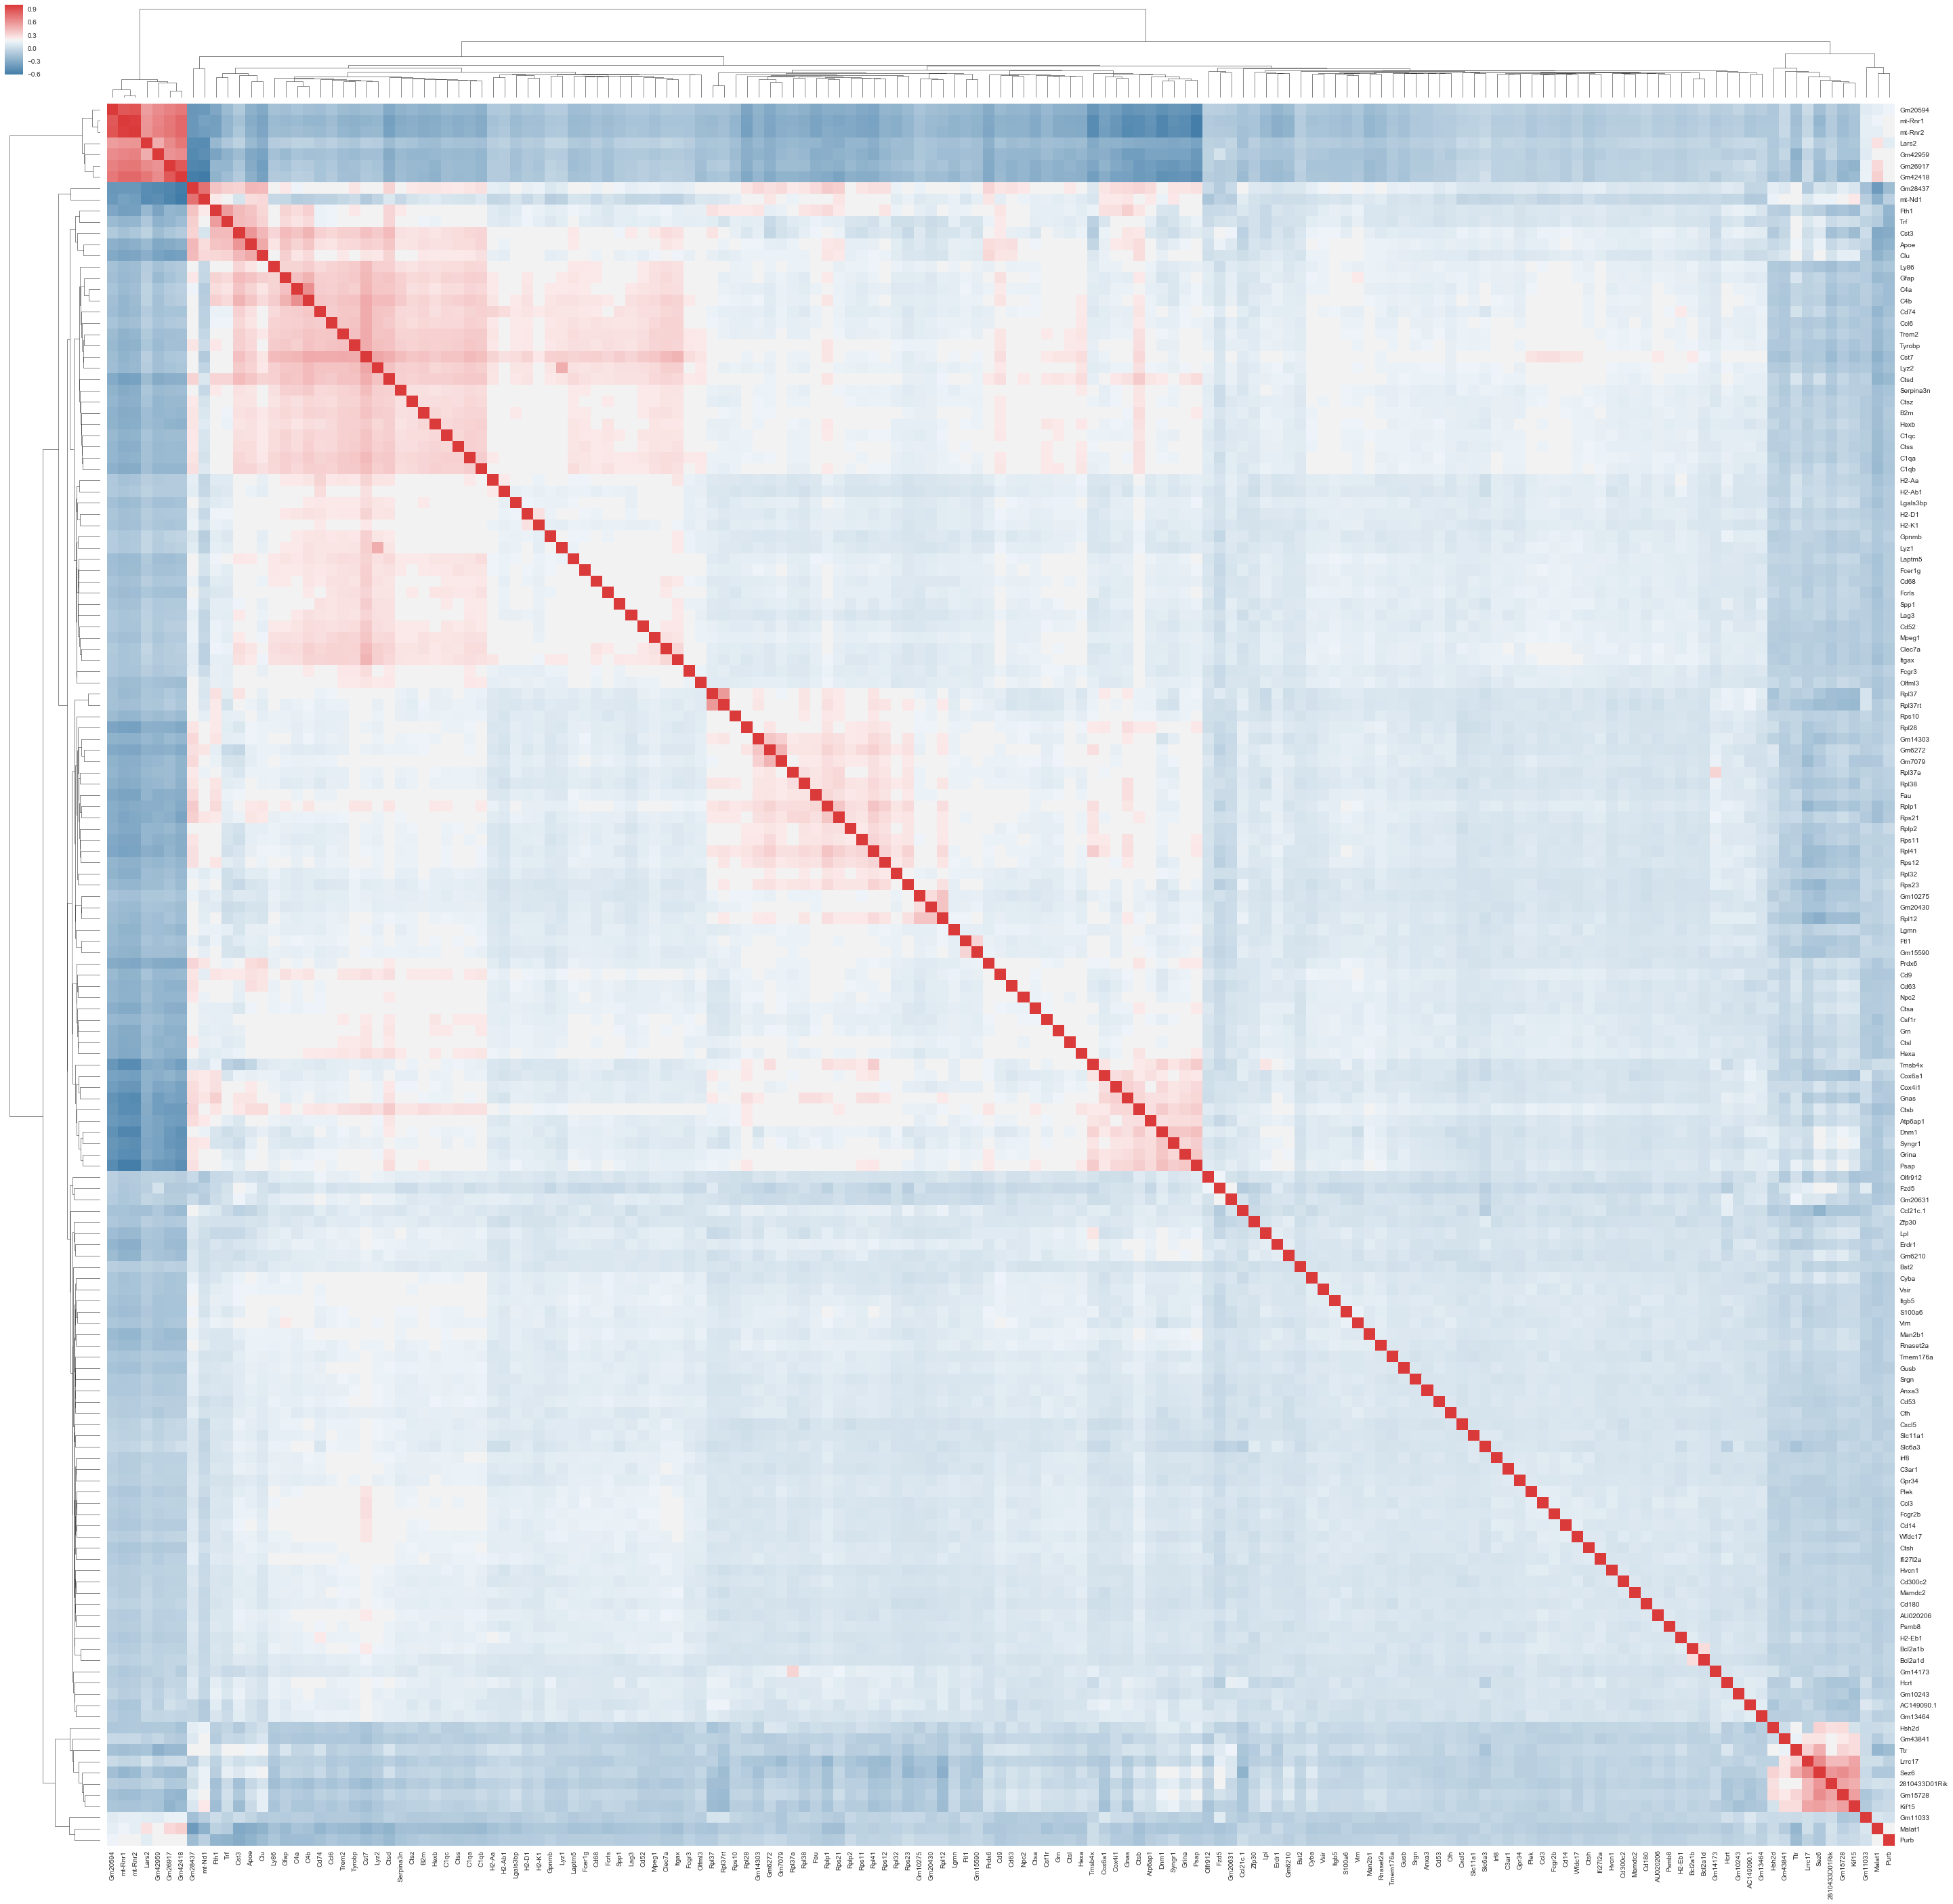

In [1029]:
corr = full_df[boruta_genes].corr()
sns.clustermap(corr, cmap=sns.diverging_palette(240, 12, as_cmap=True), figsize=(50, 50))
plt.show()

---

# Sets stratified by region and genotype
* Region: CX, BS, HP, NA
* Genotype: WT, KI

In [398]:
level_01_regions = region_df.Level_01.unique()

In [813]:
KI_region_sets = {}
KI_WT_region_sets = {}

for level_01 in level_01_regions:
    KI_region_sets[level_01]    = full_df[(full_df['Level_01'] == level_01) & (full_df['GT'] == 'KI')]    
    KI_WT_region_sets[level_01] = full_df[(full_df['Level_01'] == level_01)]

In [814]:
[(a, len(b)) for a,b in KI_region_sets.items()]

[('HP', 753), ('BS', 1516), ('NA', 849), ('CX', 1888)]

In [815]:
[(a, len(b)) for a,b in KI_WT_region_sets.items()]

[('HP', 1544), ('BS', 3028), ('NA', 1651), ('CX', 4101)]

---

# Train GBMs 
* train a GBM for every region set
* extract important features
* preliminary LIME explanations

### IDEA
* cluster the lime explanations
* t-SNE?

In [506]:
class EarlyStopMonitor:

    def __init__(self, window_length=25):
        self.window_length = window_length

    def window_boundaries(self, current_round):        
        lo = max(0, current_round - self.window_length + 1)
        hi = current_round + 1

        return lo, hi

    def __call__(self, current_round, regressor, _):        
        if current_round >= self.window_length - 1:
            lo, hi = self.window_boundaries(current_round)
            
            do_stop = np.mean(regressor.oob_improvement_[lo: hi]) < 0
            
            if do_stop:
                print('stopped after rounds: {}'.format(current_round))
            
            return do_stop
        else:
            return False

In [1011]:
# def train_sgbm(df,
#                genes=boruta_genes,
#                sgbm = GradientBoostingRegressor(learning_rate=0.001,
#                                                 n_estimators=10000,
#                                                 max_features=0.1,
#                                                 subsample=0.9,
#                                                 random_state=42)):
    
#     X = df[genes]
#     y = df['AB']
    
#     sgbm.fit(X, y, monitor=EarlyStopMonitor())
    
#     return sgbm

In [839]:
# gbm_models = {}
# gbm_importances = {}

# for level_01 in level_01_regions:
#     model = train_sgbm(KI_region_sets[level_01])
    
#     gbm_models[level_01] = model    
#     gbm_importances[level_01] = pd.DataFrame({'gene': boruta_genes, 'importance': model.feature_importances_}).sort_values(by='importance', ascending=False)

stopped after rounds: 1844
stopped after rounds: 2033
stopped after rounds: 1017
stopped after rounds: 1990


In [509]:
def train_rf(df, genes=boruta_genes):
    rf = RandomForestRegressor(n_estimators=1000, max_features='sqrt', random_state=42, n_jobs=-1)
    
    X = df[genes]
    y = df['AB']
    
    rf.fit(X, y)
    
    return rf

In [510]:
rf_models = {}
rf_importances = {}

for level_01 in region_df.Level_01.unique():        
    model = train_rf(KI_region_sets[level_01])
    
    rf_models[level_01] = model    
    rf_importances[level_01] = pd.DataFrame({'gene': boruta_genes, 'importance': model.feature_importances_}).sort_values(by='importance', ascending=False)

---
# Rank comparisons

In [848]:
def plot_rank_comparison(region,
                         gbm_importances=gbm_importances, 
                         rf_importances=rf_importances, 
                         figsize=(8,8)):
    
    gbm_ranks = gbm_importances[region].reset_index()
    gbm_ranks.index.name='rank'
    gbm_ranks.reset_index(inplace=True)
    
    rf_ranks = rf_importances[region].reset_index()
    rf_ranks.index.name='rank'
    rf_ranks.reset_index(inplace=True)
    
    merged = gbm_ranks.merge(rf_ranks, on='gene')
    
    #merged.plot.scatter(x='rank_x', y='rank_y', figsize=figsize)
    sns.regplot(data=merged, x='rank_x', y='rank_y')
    
    plt.show()

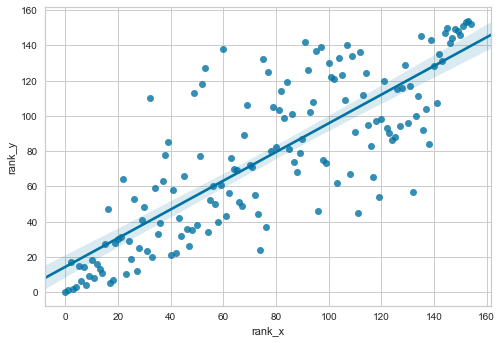

In [849]:
plot_rank_comparison('BS')

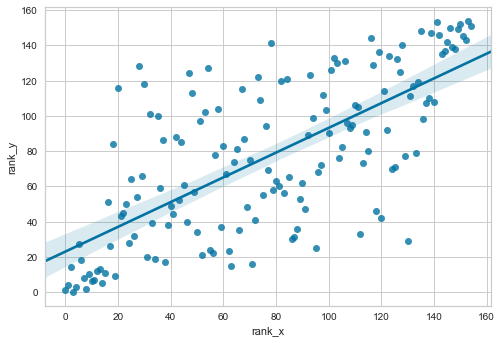

In [850]:
plot_rank_comparison('CX')

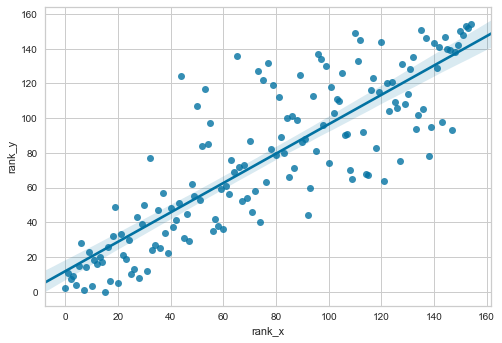

In [851]:
plot_rank_comparison('HP')

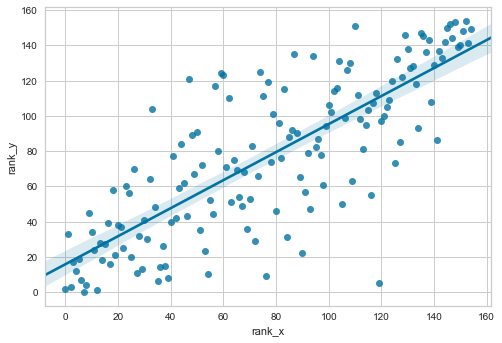

In [852]:
plot_rank_comparison('NA')

---

## write results to file

---

# Regression explainer landscape

* IDEA: extract explanations for all entries
* t-SNE cluster the explanations

# **-=[CX]=-**

* https://stackoverflow.com/questions/24132237/scikit-learn-cross-validation-scoring-for-regression
* `mean(neg_MSE) = -687744.84263418778` (eta=0.01, max_features=0.1, subsample=0.9)

In [881]:
X = KI_WT_region_sets['CX'][boruta_genes]
y = KI_WT_region_sets['CX']['AB']
GT = KI_WT_region_sets['CX']['GT']

In [882]:
cv = ShuffleSplit(n_splits=10, test_size=0.15, random_state=42)

In [1031]:
%%time
sgbm = GradientBoostingRegressor(learning_rate=0.01, n_estimators=10000, max_features=0.3, subsample=0.9, random_state=42)

scores = cross_val_score(sgbm,                          
                         X, 
                         y, 
                         cv=cv, 
                         groups=GT,                         
                         fit_params={'monitor': EarlyStopMonitor()},
                         scoring='neg_mean_squared_error',
                         n_jobs=-1)

ImportError: [joblib] Attempting to do parallel computing without protecting your import on a system that does not support forking. To use parallel-computing in a script, you must protect your main loop using "if __name__ == '__main__'". Please see the joblib documentation on Parallel for more information

In [1016]:
scores.mean()

-691828.20407847723

---

# **Process explanations**

In [611]:
def vectorize(explanation, length):
    vector = np.zeros(length)
    
    for idx, value in explanation.as_map()[1]:
        vector[idx] = value
    
    return vector

* https://stackoverflow.com/questions/21164910/delete-column-in-pandas-if-it-is-all-zeros

In [899]:
def remove_0_cols(df):
    return df.loc[:, (df !=0).any(axis=0)]

In [931]:
def to_explanations(X_train,
                    X_explain,
                    model,
                    feature_names=boruta_genes,
                    n_features=50,
                    seed=42):
    
    explainer = LimeTabularExplainer(X_train,
                                     feature_names=feature_names,
                                     discretize_continuous=False,
                                     class_names=['AB'],
                                     mode='regression',
                                     feature_selection='lasso_path',
                                     random_state=seed,
                                     verbose=True)
    
    raw_explanations = {} # Map[idx, raw_expl]
    vec_explanations = []
    
    df = X_explain
    
    for idx in df.index:        
        e = explainer.explain_instance(df.loc[idx], model.predict, num_features=n_features)
        v = vectorize(e, df.shape[1])
        
        raw_explanations[idx] = e
        vec_explanations.append(v)
    
    explanations_df = pd.DataFrame(vec_explanations)    
    explanations_df.columns = feature_names
    explanations_df.index = df.index
    
    return explanations_df, raw_explanations

In [935]:
def to_explanation_box_plots(explanations_df,
                             figsize=(30, 8)):
    
    mean_weights_df = pd.DataFrame(explanations_df.mean(axis=0)).reset_index()
    mean_weights_df.columns = ['gene', 'mean']
    mean_weights_df['abs_mean'] = mean_weights_df['mean'].abs()
    
    ordering = list(mean_weights_df.sort_values(by='abs_mean', ascending=False)['gene'])
    
    print(ordering)
    
    fig, ax = plt.subplots(figsize=figsize)
    plt.xticks(rotation=90)
    sns.boxplot(data=explanations_df.melt(), x='variable', y='value', ax=ax, order=ordering)
    plt.show()

['Cst7', 'Ctsd', 'Tyrobp', 'Gfap', 'Ccl21c.1', 'mt-Rnr1', 'B2m', 'Rplp1', 'Sez6', 'Trem2', 'Rpl12', 'C4b', 'mt-Rnr2', 'Cst3', 'Gm42418', 'Lyz2', 'Ctss', 'Ccl6', 'Cd68', 'Gm14303', 'Olfr912', 'Lrrc17', 'Fth1', 'Hexb', 'Gm28437', 'Gm6272', 'Clec7a', 'Gnas', 'C1qa', 'Cd74', 'Itgax', 'Rpl41', 'Bcl2a1d', 'Mamdc2', 'Ccl3', 'Bcl2a1b', 'Cd9', 'Lyz1', 'Cd180', 'Spp1', 'Hvcn1', 'Cxcl5', 'Cd14', 'Wfdc17', 'Mpeg1', 'H2-Aa', 'AU020206', 'Ly86', 'Apoe', 'Irf8', 'H2-Eb1', 'Ifi27l2a', 'C4a', 'Slc11a1', 'Slc6a3', 'H2-Ab1', 'C3ar1', 'Lag3', 'Cd300c2', 'Ctsb', 'Hcrt', 'Gm20631', 'Bst2', 'Fcer1g', 'Gpnmb', 'Gm15590', 'Purb', 'Cd53', 'Cd52', 'Gpr34', 'Plek', 'C1qc', 'Fcgr2b', 'Serpina3n', 'Anxa3', 'Fau', 'Gm7079', 'Psmb8', 'Olfml3', 'Erdr1', 'Rplp2', 'Lars2', 'Srgn', 'Malat1', 'Rpl38', 'Itgb5', 'Cox6a1', 'Rpl37', 'Psap', 'Rpl37a']


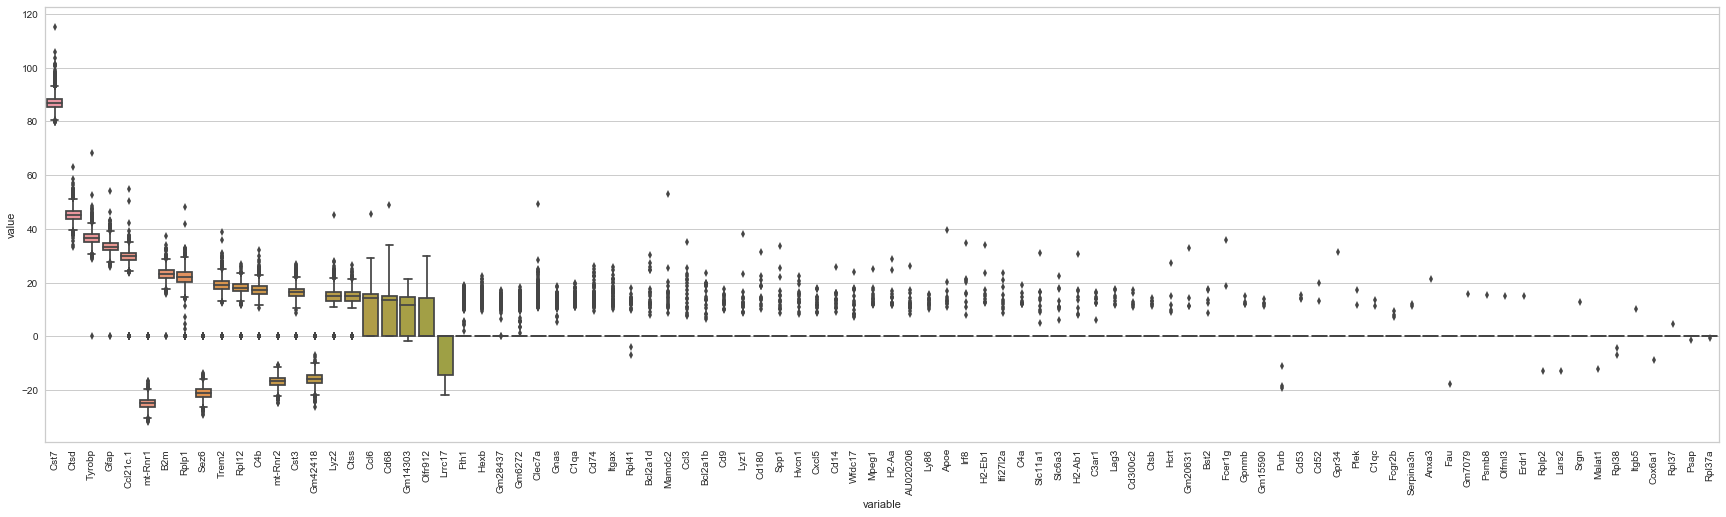

In [936]:
to_explanation_box_plots(clean_df)

In [728]:
clean_df = explanations_df.loc[:, (explanations_df != 0).any(axis=0)]

In [645]:
slide_codes = list(KI_region_sets['CX']['slide_ID'].cat.codes)

* https://stackoverflow.com/questions/20978757/how-to-append-a-vector-to-a-matrix-in-python

In [613]:
len(explanations)

4101

In [616]:
from sklearn.manifold import TSNE

In [619]:
embedding = TSNE().fit_transform(pd.DataFrame(explanations))

In [639]:
bla = pd.DataFrame(embedding)

In [682]:
selection1 = (bla[0] > -60) & (bla[0] < -44) & (bla[1] > 23) & (bla[1] < 40)

In [796]:
selection2 =  (bla[0] > 30) & (bla[0] < 40) & (bla[1] > 23) & (bla[1] < 42)

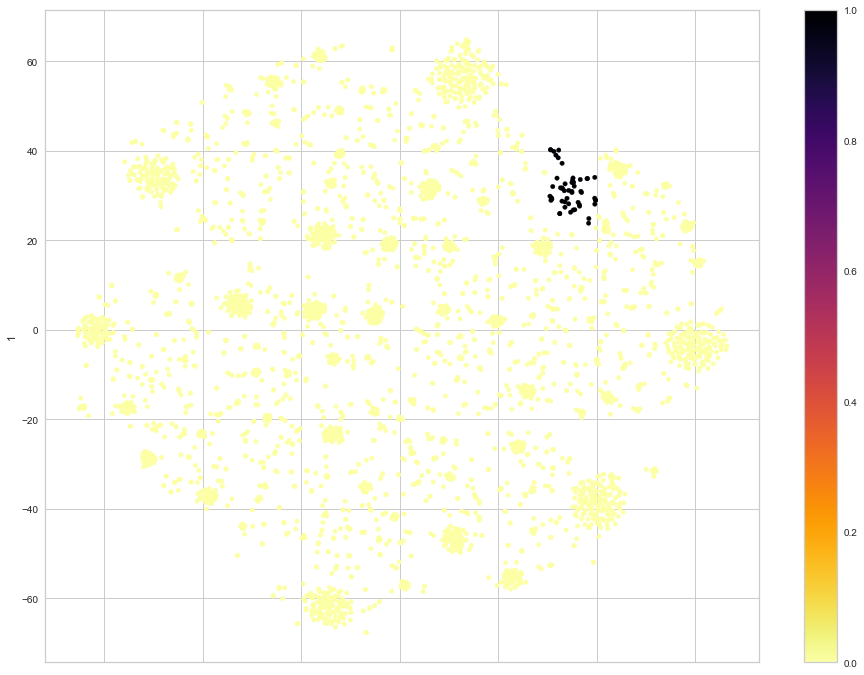

In [906]:
pd.DataFrame(embedding).plot.scatter(x=0, y=1, figsize=(16,12), c=selection2, cmap='inferno_r')
plt.show()

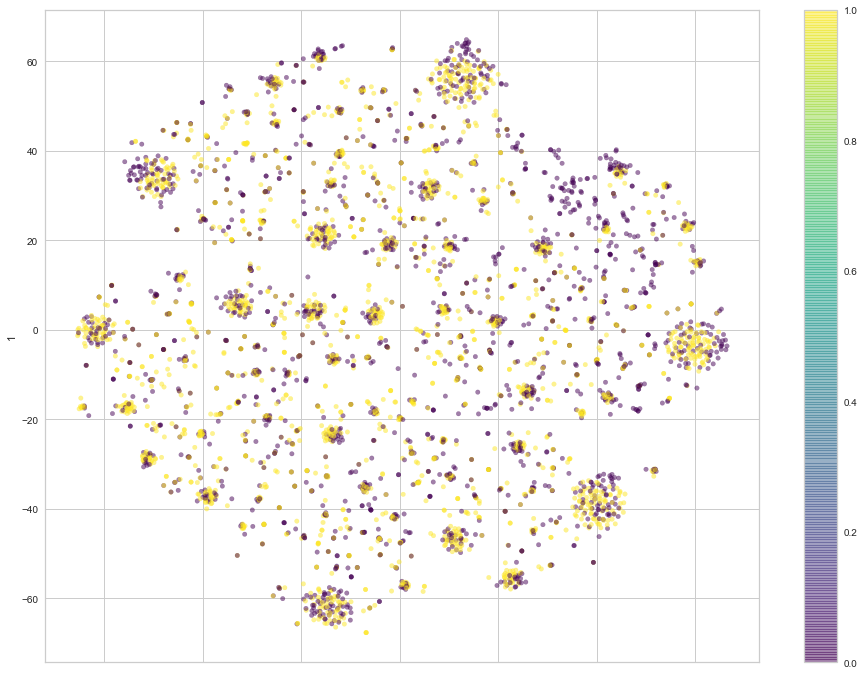

In [785]:
pd.DataFrame(embedding).plot.scatter(x=0, y=1, figsize=(16,12), alpha=0.5, c=KI_region_sets['CX']['GT'].cat.codes, cmap='viridis')
plt.show()

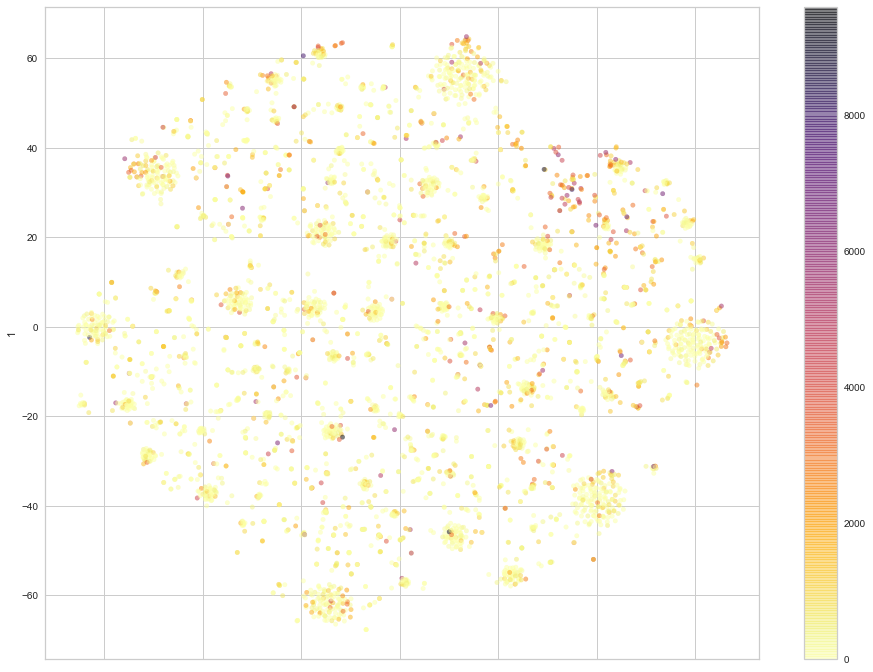

In [786]:
pd.DataFrame(embedding).plot.scatter(x=0, y=1, figsize=(16,12), alpha=0.5, c=KI_region_sets['CX']['AB'], cmap='inferno_r')
plt.show()

In [937]:
ordered_genes = ['Cst7', 'Ctsd', 'Tyrobp', 'Gfap', 'Ccl21c.1', 'mt-Rnr1', 'B2m', 'Rplp1', 'Sez6', 'Trem2', 'Rpl12', 'C4b', 'mt-Rnr2', 'Cst3', 'Gm42418', 'Lyz2', 'Ctss', 'Ccl6', 'Cd68', 'Gm14303', 'Olfr912', 'Lrrc17', 'Fth1', 'Hexb', 'Gm28437', 'Gm6272', 'Clec7a', 'Gnas', 'C1qa', 'Cd74', 'Itgax', 'Rpl41', 'Bcl2a1d', 'Mamdc2', 'Ccl3', 'Bcl2a1b', 'Cd9', 'Lyz1', 'Cd180', 'Spp1', 'Hvcn1', 'Cxcl5', 'Cd14', 'Wfdc17', 'Mpeg1', 'H2-Aa', 'AU020206', 'Ly86', 'Apoe', 'Irf8', 'H2-Eb1', 'Ifi27l2a', 'C4a', 'Slc11a1', 'Slc6a3', 'H2-Ab1', 'C3ar1', 'Lag3', 'Cd300c2', 'Ctsb', 'Hcrt', 'Gm20631', 'Bst2', 'Fcer1g', 'Gpnmb', 'Gm15590', 'Purb', 'Cd53', 'Cd52', 'Gpr34', 'Plek', 'C1qc', 'Fcgr2b', 'Serpina3n', 'Anxa3', 'Fau', 'Gm7079', 'Psmb8', 'Olfml3', 'Erdr1', 'Rplp2', 'Lars2', 'Srgn', 'Malat1', 'Rpl38', 'Itgb5', 'Cox6a1', 'Rpl37', 'Psap', 'Rpl37a']

In [940]:
ordered_genes[:22]

['Cst7',
 'Ctsd',
 'Tyrobp',
 'Gfap',
 'Ccl21c.1',
 'mt-Rnr1',
 'B2m',
 'Rplp1',
 'Sez6',
 'Trem2',
 'Rpl12',
 'C4b',
 'mt-Rnr2',
 'Cst3',
 'Gm42418',
 'Lyz2',
 'Ctss',
 'Ccl6',
 'Cd68',
 'Gm14303',
 'Olfr912',
 'Lrrc17']

In [941]:
cx_boruta_embedding = TSNE().fit_transform(KI_WT_region_sets['CX'][ordered_genes[:22]])

In [1007]:
AB = KI_WT_region_sets['CX']['AB']
GT = KI_WT_region_sets['CX']['GT'].cat.codes
age = KI_WT_region_sets['CX']['age'].cat.codes
age_GT = KI_WT_region_sets['CX']['age_GT'].cat.codes
slide = KI_WT_region_sets['CX']['slide_ID'].cat.codes

In [997]:
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
#flatui = ["#34495e", "#2ecc71"]
my_cmap = ListedColormap(sns.color_palette(flatui[:4]).as_hex())

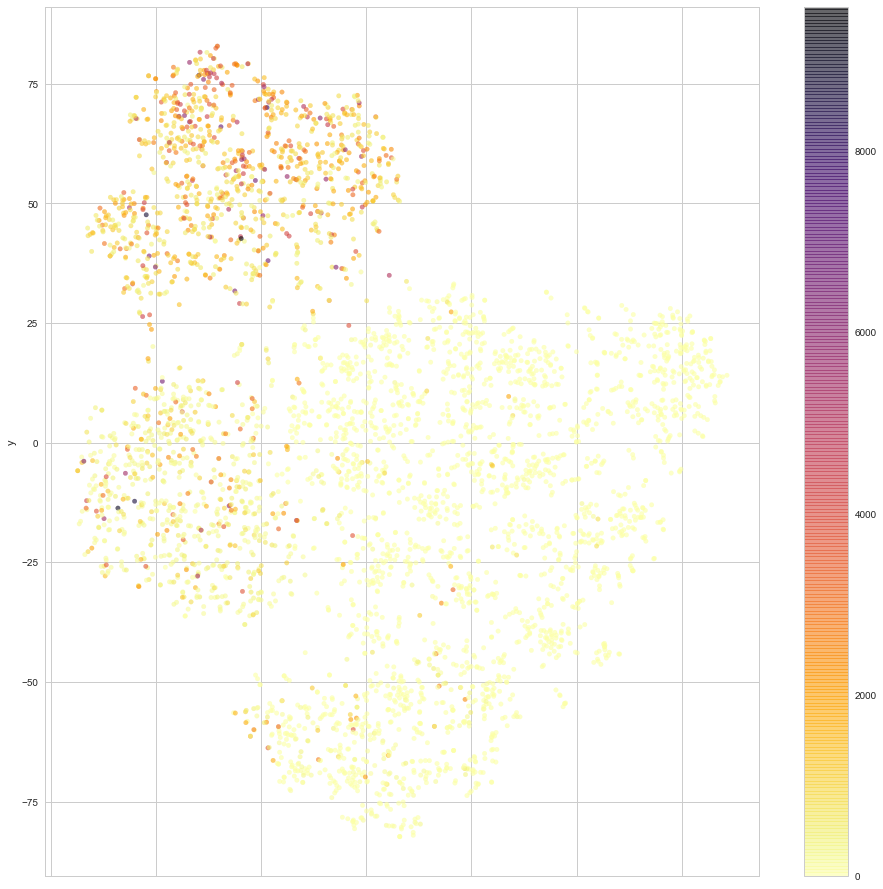

In [1000]:
pd.DataFrame(cx_boruta_embedding, columns=['x', 'y']).plot.scatter(x='x', y='y', c=AB, alpha=0.6, cmap='inferno_r', figsize=(16,16))
plt.show()

array([0, 2, 1, 3])

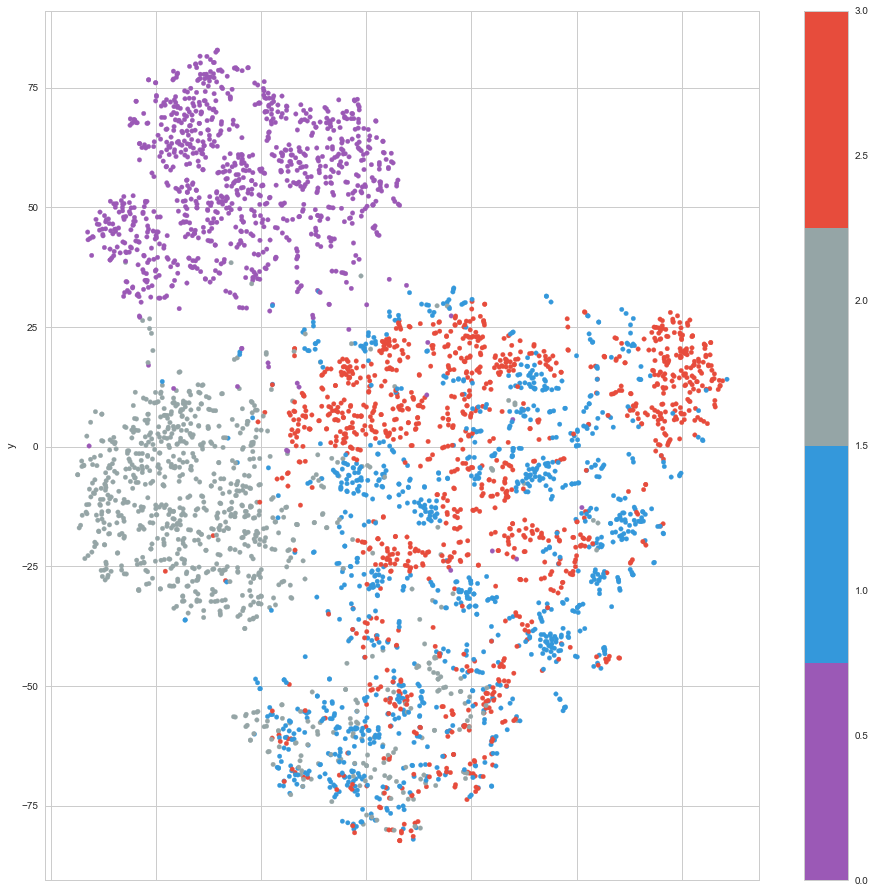

In [1008]:
pd.DataFrame(cx_boruta_embedding, columns=['x', 'y']).plot.scatter(x='x', y='y', c=age, cmap=my_cmap, figsize=(16,16))
plt.show()

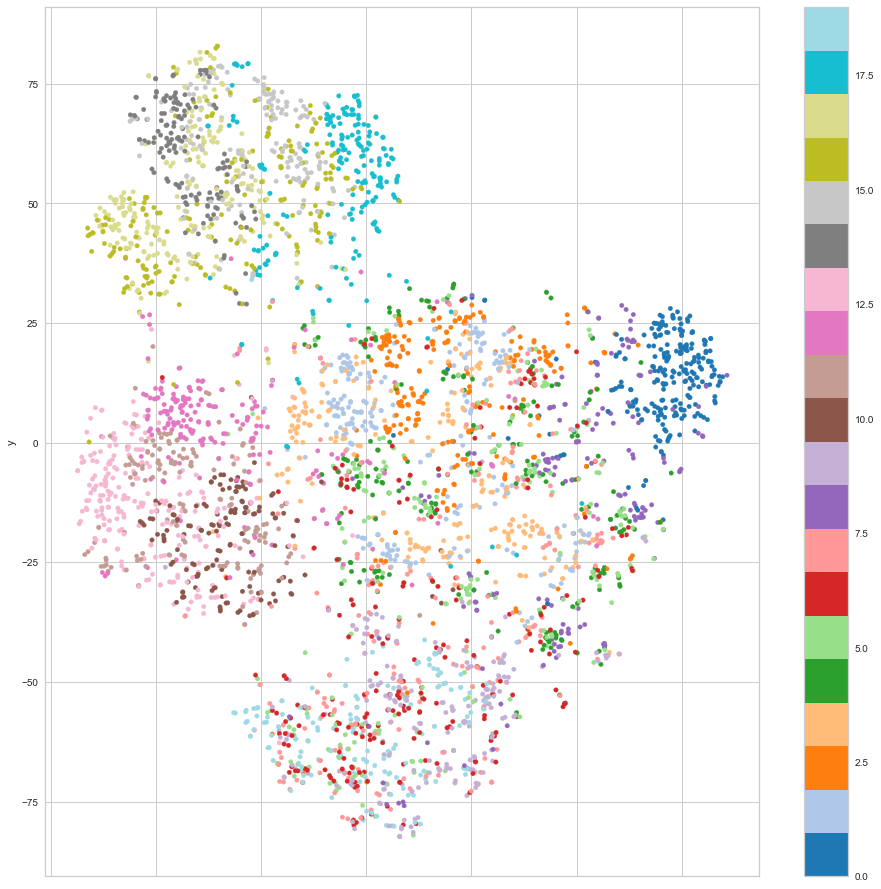

In [956]:
pd.DataFrame(cx_boruta_embedding, columns=['x', 'y']).plot.scatter(x='x', y='y', c=slide, cmap='tab20', figsize=(16,16))
plt.show()

In [ ]:
pd.DataFrame(cx_boruta_embedd